In [28]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Start working from the aggregated dataframe `agg_df`.

In [29]:
train_df = pd.read_pickle(f'{PATH_FEATURES}/agg_df_159.pkl')

train_df.head()

,bookingID,Accuracy_mean,Accuracy_min,Accuracy_max,Accuracy_std,Accuracy_fo_mean,Accuracy_so_mean,Accuracy_fo_min,Accuracy_so_min,Accuracy_fo_max,Accuracy_so_max,Bearing_mean,Bearing_min,Bearing_max,Bearing_std,Bearing_fo_mean,Bearing_so_mean,Bearing_fo_min,Bearing_so_min,Bearing_fo_max,Bearing_so_max,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_x_fo_min,acceleration_x_so_min,acceleration_x_fo_max,acceleration_x_so_max,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_y_fo_min,acceleration_y_so_min,acceleration_y_fo_max,...,total_gyro_fo_max,total_gyro_so_max,roll_mean,roll_min,roll_max,roll_std,roll_fo_mean,roll_so_mean,roll_fo_min,roll_so_min,roll_fo_max,roll_so_max,pitch_mean,pitch_min,pitch_max,pitch_std,pitch_fo_mean,pitch_so_mean,pitch_fo_min,pitch_so_min,pitch_fo_max,pitch_so_max,horsepower_mean,horsepower_min,horsepower_max,horsepower_std,horsepower_fo_mean,horsepower_so_mean,horsepower_fo_min,horsepower_so_min,horsepower_fo_max,horsepower_so_max,vc,Speed_1,Speed_1_2,Speed_1_2_3,horsepower_1,horsepower_1_2,horsepower_1_2_3,label
0,0,10.165339,4.0,48.000,3.855898,-3.988036e-03,0.003992,-36.000,-68.000,32.000,32.000,176.526099,0.037464,359.979767,129.231351,-0.101603,-0.280284,-356.680084,-678.707878,357.773807,697.542567,-0.711264,-4.692294,4.782614,0.928022,-0.001451,-0.001960,-5.310925,-10.184308,4.873383,8.453427,-9.613822,-12.764703,-6.119916,0.639934,0.000324,0.000934,-3.953137,-7.856479,3.903342,...,0.660225,0.732735,-1.737242,-2.229817,-1.347602,0.116742,0.000171,0.000202,-0.470042,-0.940743,0.615583,1.047816,0.073598,-0.425732,0.447192,0.094192,0.000157,0.000210,-0.441226,-0.853901,0.505558,0.918500,89.169004,-10.169692,252.090958,71.968693,8.359973e-02,-4.773332e-02,-232.745306,-460.166618,231.245321,400.555202,1004,-1.000000,10.590596,0.162426,-10.169692,131.702010,1.613122,0
1,1,3.718763,3.0,7.709,0.597933,1.058824e-03,-0.001296,-4.414,-8.828,4.709,6.709,124.198590,0.000000,337.000000,89.861236,0.038824,-0.047114,-306.000000,-559.000000,304.000000,610.000000,-0.525406,-5.352994,3.813341,0.744157,-0.000824,0.001334,-4.131128,-8.524900,5.112138,8.847361,9.532086,6.623425,12.536156,0.533915,-0.000785,0.000634,-3.323172,-6.294559,3.170564,...,0.641245,0.657876,1.797626,1.434715,2.137340,0.088049,-0.000096,-0.000285,-0.537245,-0.783427,0.523479,0.965273,0.053107,-0.421987,0.512452,0.074387,0.000099,-0.000123,-0.488136,-0.832619,0.452367,0.931832,77.562771,-10.135306,233.266532,69.489840,1.848545e-01,-1.158458e-01,-225.490708,-453.960890,233.169493,411.608531,851,-1.000000,-1.000000,-1.000000,-9.197917,-9.093537,-9.465303,1
2,2,3.930626,3.0,8.000,1.117354,4.639175e-03,0.001793,-4.000,-8.345,5.000,6.000,173.794872,1.000000,354.000000,119.316520,1.010309,1.388601,-337.000000,-676.000000,339.000000,590.000000,0.306786,-2.971295,1.956122,0.756589,0.003345,0.018050,-3.644086,-5.013611,3.464516,7.108602,9.843183,7.941810,13.333716,0.505693,0.001592,0.003449,-3.490852,-6.522003,3.031151,...,0.407373,0.563150,1.556422,1.328230,1.891112,0.102860,-0.000391,-0.000621,-0.436176,-0.777169,0.478420,0.635099,-0.031534,-0.202880,0.260122,0.075406,-0.000304,-0.001784,-0.310418,-0.639641,0.329223,0.490599,31.450526,0.000000,104.777363,29.000906,4.596758e-01,4.409695e-01,-93.238772,-186.477544,93.238772,173.380469,195,9.002391,9.257438,8.185837,92.667590,104.777363,83.435178,1
3,4,10.000000,10.0,10.000,0.000000,0.000000e+00,0.000000,0.000,0.000,0.000,0.000,151.807013,2.271227,353.855377,71.273774,0.024552,0.006779,-300.273964,-508.312253,331.624398,594.888779,-0.365117,-2.866458,2.019635,0.527220,-0.001801,0.001724,-3.085678,-5.133127,3.158801,5.254550,-9.406439,-18.847833,-7.064984,0.598023,0.000358,-0.000093,-9.794467,-10.051071,9.601715,...,0.625971,0.967315,-1.841256,-2.107056,-1.537207,0.077592,-0.000184,0.000134,-0.366293,-0.728194,0.371167,0.595339,0.03

In [95]:
select_f = features_df['features'].tolist()

len(select_f)

39

In [88]:
exclude = ['label', 'bookingID']

# features = [c for c in train_df.columns if c not in exclude]


features = select_f

len(features)

39

## Baseline
1. `lightgbm`
2. [CNN](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution)

In [0]:
random_state = 42
np.random.seed(random_state)

folds=5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

In [0]:
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'lambda_l1': 5,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

In [105]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], 
                              num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.831121	valid_1's auc: 0.738587
[200]	training's auc: 0.885249	valid_1's auc: 0.737818
Early stopping, best iteration is:
[140]	training's auc: 0.855344	valid_1's auc: 0.740947
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.82794	valid_1's auc: 0.734406
[200]	training's auc: 0.882553	valid_1's auc: 0.735151
Early stopping, best iteration is:
[152]	training's auc: 0.858466	valid_1's auc: 0.737151
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.828012	valid_1's auc: 0.745395
[200]	training's auc: 0.881716	valid_1's auc: 0.746444
Early stopping, best iteration is:
[196]	training's auc: 0.880111	valid_1's auc: 0.746623
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.83261	valid_1's auc: 0.735693
[200]	training's auc: 0.885806	valid_1's auc: 0.733284
Early stopping, best iteration is:
[115]

In [106]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.737470248, std: 0.006237511. All auc: 0.737418898.


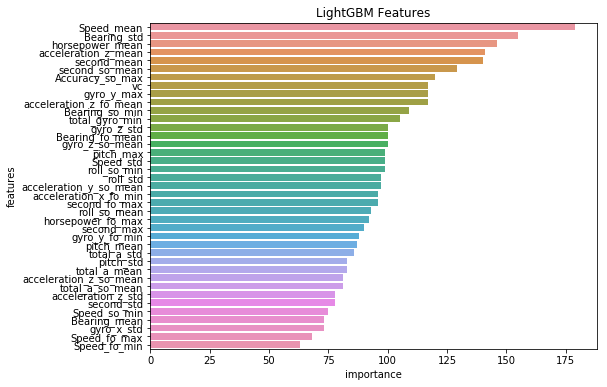

In [107]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

# features_df = features_df[:int(len(features)/2)]

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="features", 
            data=features_df)
plt.title('LightGBM Features')
plt.show()